# CNN Connect 4 Model
[How AlphaGo works](https://jonathan-hui.medium.com/alphago-how-it-works-technically-26ddcc085319)

**How to use your gpu**

run this in a terminal
```
python -m venv ~/venv-tfmetal
source ~/venv-tfmetal/bin/activate
python -m pip install --upgrade pip
python -m pip install tensorflow
python -m pip install tensorflow-metal
python -m pip install jupyterlab
python -m pip install ipykernel
python -m ipykernel install --user --name=tfmetal --display-name "Python (tfmetal)"
```
Now select the new kernel "Python (tfmetal)" when you open jupyter lab

If you need to install additional packages, then activate the environment again and install the required packages:

```
source ~/venv-tfmetal/bin/activate
pip install pandas numpy tensorflow keras-tuner matplotlib scikit-learn
pip list
```

**To share depdencies for future use:**
```
pip freeze > requirements.txt
pip install -r requirements.txt
```

In [5]:
from google.colab import drive
drive.mount('/content/drive')
# ! pip install -r "/content/drive/My Drive/requirements.txt"
! pip install keras-tuner==1.4.7

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.0 MB/s eta 0:00:00


In [6]:
# confirm package versions
! pip freeze
!pip freeze > requirements2.txt

absl-py==1.4.0
accelerate==1.3.0
aiohappyeyeballs==2.4.6
aiohttp==3.11.12
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.23
albumentations==2.0.4
ale-py==0.10.1
altair==5.5.0
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.6.0
arviz==0.20.0
astropy==7.0.1
astropy-iers-data==0.2025.2.10.0.33.26
astunparse==1.6.3
atpublic==4.1.0
attrs==25.1.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
beautifulsoup4==4.13.3
betterproto==2.0.0b6
bigframes==1.36.0
bigquery-magics==0.5.0
bleach==6.2.0
blinker==1.9.0
blis==0.7.11
blosc2==3.0.0
bokeh==3.6.3
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
CacheControl==0.14.2
cachetools==5.5.1
catalogue==2.0.10
certifi==2025.1.31
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.1
chex==0.1.88
clarabel==0.10.0
click==8.1.8
cloudpathlib==0.20.0
cloudpickle==3.1.1
cmake==3.31.4
cmdstanpy==1.2.5
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.5
cons==0.4

In [7]:
# Check environment being used!!
import sys
print(sys.version) # should be 3.9.19 to match Femke's

# either use virtual environment or use requirements.txt versions by running the line below
# your python version still might not be right though, so using the virtual environment is the safest.
# Also, if you use a package that isn't installed in the virtual environment, then you can take note of it
# and we can add it
# Can also use this to reset packages to the proper versions within requirements.txt in case you changed anything

# !pip install -r requirements.txt

3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]


In [8]:
# Install if needed

# libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.model_selection import train_test_split
import pickle

In [9]:
# dataset
df = pd.read_pickle('/content/drive/My Drive/MCTS7500_6-7-2shape_cleaned_larger.pkl')

In [10]:
x = df["x"]
y = df["y"]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 22)

X_train = np.stack(X_train)
X_test = np.stack(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

## CNN Structure Rationale

Since your input is a small 6×7×2 tensor, a very deep CNN isn’t necessary, but you still need enough complexity to detect winning patterns, threats, and board control. Let's break down the reasoning behind each choice:

**1. Number of Convolutional Layers (3–4)**
- Too few: Won’t capture complex board patterns.
- Too many: Overfitting risk, unnecessary computational cost.
- 3–4 layers allow the network to extract hierarchical features:
- Layer 1: Detects basic features like piece locations.
- Layer 2: Identifies column stacking and potential wins/losses.
- Layer 3–4: Captures advanced threats and strategic moves.
  
**2. Number of Filters (32 → 64 → 128)**
- Why increase filters? Deeper layers capture more abstract features.
- Too few filters: Can’t capture strategic depth.
- Too many: Increases computation with diminishing returns.

**3. Kernel Size (3×3 or 2×2)**
- Why not 5×5? Your board is small; larger kernels reduce spatial information.
- 3×3 is ideal for detecting piece patterns while keeping spatial resolution.

**4. Dropout Placement**
- Why after convolutional layers? Convolutions extract features; dropout too early might erase important ones.
- Best place: After dense layers, before final prediction, to prevent overfitting.
- Level: 0.3–0.5 is a good range.

**6. Regularization (L2)**
- Helps control overfitting.
- Works best inside convolutional and dense layers, not between them.

**7. Dense Layers (1 or 2)**
- Too many: Unnecessary complexity.
- 64–128 neurons are enough to process extracted features.
- Final layer: 7 neurons (softmax), one per column.

In [11]:
def model_builder(hp):
    model = tf.keras.Sequential()

    model.add(layers.Input(shape=(6, 7, 2)))  # Input shape is (height=6, width=7, channels=2)

    # Set for all convolutional layers
    conv_reg = keras.regularizers.l2(hp.Choice('conv_l2', [0.0001, 0.001, .005]))

    # First convolutional layer
    kernel_size_1 =  hp.Choice('conv_kernel_size_1', values=[3,4])
    filters_1 = hp.Choice('conv_filters_1', values=[32, 64, 128])
    model.add(layers.Conv2D(
        filters=filters_1,
        kernel_size=(kernel_size_1, kernel_size_1), # kernel = (3,3) or (4,4)
        activation=tf.nn.relu,
        kernel_regularizer=conv_reg,
        padding='same'  # Ensure padding to avoid output size issues
        )
    )

    # Second convolutional layer
    kernel_size_2 =  hp.Choice('conv_kernel_size_2', values=[3,4])
    factor = hp.Choice('conv_filters_2_factor', values=[1,2])
    filters_2 = filters_1 * factor # increase or keep number of filters the same
    model.add(layers.Conv2D(
        filters=filters_2,
        kernel_size=(kernel_size_2, kernel_size_2), # kernel = (3,3) or (4,4)
        activation=tf.nn.relu,
        kernel_regularizer=conv_reg,
        padding='same'  # Ensure padding to avoid output size issues
        )
    )

    # Third convolutional layer
    kernel_size_3 =  hp.Choice('conv_kernel_size_3', values=[3,4])
    factor = hp.Choice('conv_filters_3_factor', values=[1,2])
    filters_3 = filters_2 * factor # increase or keep number of filters the same
    model.add(layers.Conv2D(
        filters=filters_3,
        kernel_size=(kernel_size_3, kernel_size_3), # kernel = (3,3) or (4,4)
        activation=tf.nn.relu,
        kernel_regularizer=conv_reg,
        padding='same'  # Ensure padding to avoid output size issues
        )
    )

    # Fourth convolutional layer (optional)
    if hp.Boolean('use_4_conv'):
        kernel_size_4 =  hp.Choice('conv_kernel_size_4', values=[3,4])
        factor = hp.Choice('conv_filters_4_factor', values=[1,2])
        filters_4 = filters_3 * factor # increase or keep number of filters the same
        model.add(layers.Conv2D(
            filters=filters_4,
            kernel_size=(kernel_size_4, kernel_size_4), # kernel = (3,3) or (4,4)
            activation=tf.nn.relu,
            kernel_regularizer=conv_reg,
            padding='same'  # Ensure padding to avoid output size issues
            )
        )

    # Flatten before dense layers
    model.add(layers.Flatten())

    # First dense layer
    model.add(layers.Dense(
        units=hp.Int('dense_units_1', min_value=32, max_value=128, step=32),
        activation=tf.nn.relu,
        kernel_regularizer=keras.regularizers.l2(hp.Choice('l2_dense1', [0.0001, 0.001, 0.005]))
        )
    )

    # Second dense layer (optional)
    if hp.Boolean('use_dense_2'):
        model.add(layers.Dense(
            units=hp.Int('dense_units_2', min_value=32, max_value=128, step=32),
            activation=tf.nn.relu,
            kernel_regularizer=keras.regularizers.l2(hp.Choice('l2_dense2', [0.0001, 0.001, 0.005]))
            )
        )

    # Optional droppout (could set to 0)
    model.add(layers.Dropout(
        hp.Float('dropout', min_value=0, max_value=0.4, step=0.1)
        )
    )

    model.add(layers.Dense(7,activation=tf.nn.softmax))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate = hp.Choice('learning_rate', values = [0.1, 0.001, 0.0001])
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [12]:
# now we have a tunable model; set up kt.Hyperband
# hyperband paper: https://arxiv.org/pdf/1603.06560

tuner = kt.Hyperband(model_builder,
                    objective = 'val_accuracy',
                    max_epochs = 10,
                    factor = 3,
                    # hyperband_iterations=2,
                    directory = '/content/drive/My Drive/cnn_tuning',
                    project_name = 'cnn_tuning_DansData_larger'#,
                    #overwrite=True
                    )

In [13]:
# add early stopping to reduce training time
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5)

# now run the search
tuner.search(X_train, y_train, epochs = 50, validation_split = 0.2, callbacks=[stop_early]) # arguments passed to model.fit(), default batch size of 32 used

Trial 30 Complete [00h 05m 50s]
val_accuracy: 0.5872519016265869

Best val_accuracy So Far: 0.6441869735717773
Total elapsed time: 01h 11m 02s


In [25]:
# to see top 10 results
tuner.results_summary()

# to get all results
# Initialize a list to collect trial data
trial_data = []

# Iterate over all trials in the tuner
for trial_id, trial in tuner.oracle.trials.items():
    trial_info = trial.hyperparameters.values  # Get hyperparameters
    trial_info['trial_id'] = trial_id  # Add trial ID

    # Extract validation accuracy (or set NaN if not available)
    val_accuracy = trial.metrics.get_last_value('val_accuracy')
    trial_info['val_accuracy'] = val_accuracy if val_accuracy is not None else float('nan')

    trial_data.append(trial_info)

# Convert to DataFrame
df_trials = pd.DataFrame(trial_data).sort_values(by='val_accuracy', ascending=False)

# Display DataFrame
display(df_trials)

Results summary
Results in /content/drive/My Drive/cnn_tuning/cnn_tuning_DansData_larger
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0028 summary
Hyperparameters:
conv_l2: 0.001
conv_kernel_size_1: 4
conv_filters_1: 128
conv_kernel_size_2: 4
conv_filters_2_factor: 2
conv_kernel_size_3: 4
conv_filters_3_factor: 1
use_4_conv: True
dense_units_1: 64
l2_dense1: 0.005
use_dense_2: False
dropout: 0.0
learning_rate: 0.0001
conv_kernel_size_4: 3
conv_filters_4_factor: 1
dense_units_2: 64
l2_dense2: 0.0001
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
trial_id: 0028
val_accuracy: 0.6441869735717773
Score: 0.6441869735717773

Trial 0024 summary
Hyperparameters:
conv_l2: 0.0001
conv_kernel_size_1: 4
conv_filters_1: 32
conv_kernel_size_2: 4
conv_filters_2_factor: 2
conv_kernel_size_3: 4
conv_filters_3_factor: 1
use_4_conv: True
dense_units_1: 64
l2_dense1: 0.001
use_dense_2: False
dropout: 0.0
learning_rate: 0.0001
conv_kernel_size_4: 4
c

,conv_l2,conv_kernel_size_1,conv_filters_1,conv_kernel_size_2,conv_filters_2_factor,conv_kernel_size_3,conv_filters_3_factor,use_4_conv,dense_units_1,l2_dense1,...,tuner/initial_epoch,tuner/bracket,tuner/round,conv_kernel_size_4,conv_filters_4_factor,dense_units_2,l2_dense2,trial_id,val_accuracy,tuner/trial_id
28,0.0010,4,128,4,2,4,1,True,64,0.0050,...,0,0,0,3,1,64,0.0001,0028,0.644187,NaN
24,0.0001,4,32,4,2,4,1,True,64,0.0010,...,4,1,1,4,2,128,0.0010,0024,0.627174,0019
16,0.0010,3,32,4,2,4,2,False,128,0.0001,...,4,2,2,3,1,32,0.0001,0016,0.612459,0012
27,0.0001,4,64,3,1,4,1,True,128,0.0050,...,0,0,0,4,2,96,0.0050,0027,0.607611,NaN
29,0.0010,4,64,4,1,4,2,True,32,0.0001,...,0,0,0,3,1,96,0.0010,0029,0.587252,NaN
12,0.0010,3,32,4,2,4,2,False,128,0.0001,...,2,2,1,3,1,32,0.0001,0012,0.583952,0003
17,0.0010,3,64,3,1,3,2,False,96,0.0010,...,4,2,2,4,1,64,0.0001,0017,0.579217,0013
25,0.0050,4,32,3,2,4,1,False,96,0.0001,...,4,1,1,3,2,128,0.0001,0025,0.578569,0021
19,0.0001,4,32,4,2,4,1,True,64,0.0010,...,0,1,0,4,2,128,0.0010,0019,0.573869,NaN
26,0.0050,3,64,4,2,4,2,True,32,0.0050,...,0,0,0,3,2,64,0.0010,0026,0.561931,NaN


,val_accuracy
val_accuracy,1.000000
dropout,0.514741
conv_kernel_size_3,0.335391
conv_l2,0.247096
dense_units_1,0.164114
conv_filters_2_factor,0.157451
dense_units_2,0.138870
conv_filters_4_factor,0.131430
conv_kernel_size_2,0.106567
conv_kernel_size_4,0.098074


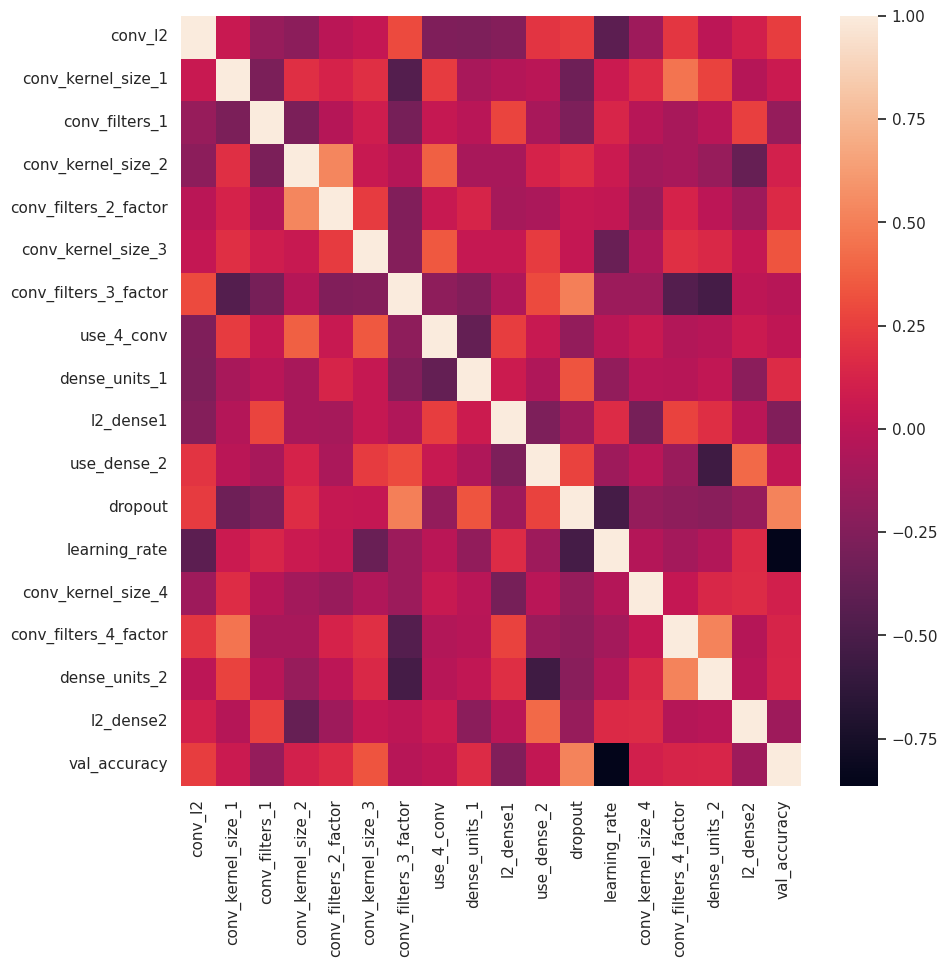

In [26]:
# examining tuner results more: correlation
# correlation between everything
cols_to_remove = ['tuner/epochs', 'tuner/initial_epoch',
       'tuner/bracket', 'tuner/round','tuner/trial_id', 'trial_id']
df_trials2 = df_trials.drop(columns = cols_to_remove)
plt.figure(figsize=(10,10))
sns.heatmap(df_trials2.corr())

df_trials2.corr()['val_accuracy'].sort_values(ascending=False)

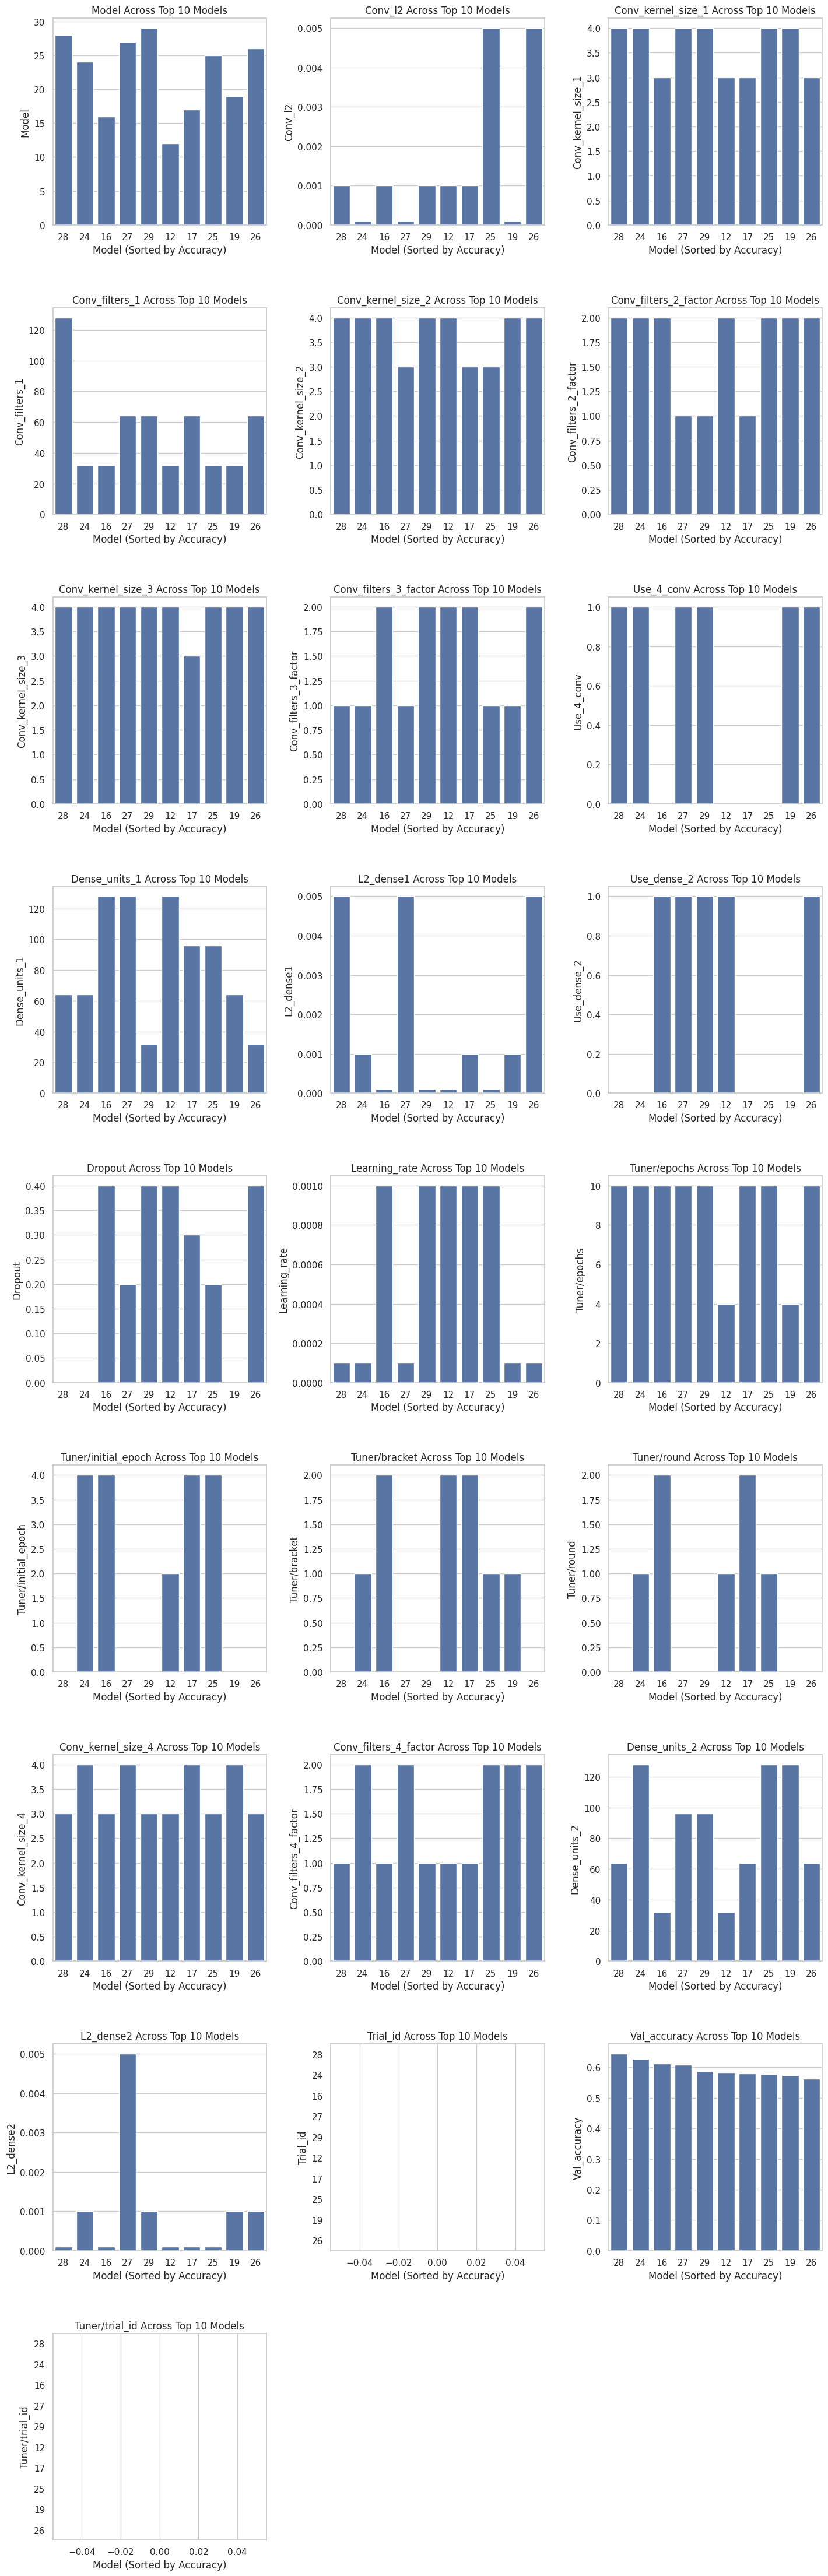

In [27]:
# exmaining tuner results more: plotting
import matplotlib.pyplot as plt
import seaborn as sns

df_trials = df_trials.reset_index().rename(columns={'index': 'Model'})

# Keep only the top 10 models
df_trials = df_trials.head(10)

# Sort by validation accuracy
df_trials = df_trials.sort_values(by='val_accuracy', ascending=False)

# List of hyperparameters to plot
hyperparameters = df_trials.columns.tolist()

# Set up the figure and subplots
num_params = len(hyperparameters)
cols = 3  # Set number of columns to 3
rows = (num_params + 2) // cols  # Calculate number of rows needed (round up if necessary)

# Set Seaborn style
sns.set(style="whitegrid")

# Create the subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))

# Flatten axes for easy iteration (in case of a single row)
axes = axes.flatten()

# Loop through each hyperparameter and plot
for i, param in enumerate(hyperparameters):
    sns.barplot(x='Model', y=param, data=df_trials, order=df_trials['Model'], ax=axes[i])

    # Titles and labels
    axes[i].set_title(f'{param.capitalize()} Across Top 10 Models')
    axes[i].set_xlabel('Model (Sorted by Accuracy)')
    axes[i].set_ylabel(param.capitalize())

# Remove empty subplots if the number of hyperparameters is odd
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better spacing
plt.tight_layout(pad=3.0)  # Padding between subplots
plt.subplots_adjust(hspace=0.4, wspace=0.3)  # More padding between rows and columns

plt.show()

In [28]:
# get the best hyperparameters out:

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")

conv_l2: 0.001
conv_kernel_size_1: 4
conv_filters_1: 128
conv_kernel_size_2: 4
conv_filters_2_factor: 2
conv_kernel_size_3: 4
conv_filters_3_factor: 1
use_4_conv: True
dense_units_1: 64
l2_dense1: 0.005
use_dense_2: False
dropout: 0.0
learning_rate: 0.0001
conv_kernel_size_4: 3
conv_filters_4_factor: 1
dense_units_2: 64
l2_dense2: 0.0001
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
trial_id: 0028
val_accuracy: 0.6441869735717773


In [29]:
# train the best model on the full dataset

best_model = tuner.hypermodel.build(best_hps)

best_model.summary()

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10)

history = best_model.fit(
    X_train, y_train,
    epochs=100,
    validation_split = 0.2,
    callbacks=[stop_early]
)

test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

# save the best model for future use
best_model.save('/content/drive/My Drive/best_connect4_cnn.h5')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 6, 7, 128)           │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 6, 7, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 6, 7, 256)           │       1,048,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 6, 7, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 10752)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │         688,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,856,327 (10.90 MB)

 Trainable params: 2,856,327 (10.90 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
10984/10984 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.4123 - loss: 1.6923 - val_accuracy: 0.5616 - val_loss: 1.2486
Epoch 2/100
10984/10984 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.5719 - loss: 1.2241 - val_accuracy: 0.5873 - val_loss: 1.1774
Epoch 3/100
10984/10984 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.6014 - loss: 1.1505 - val_accuracy: 0.6027 - val_loss: 1.1457
Epoch 4/100
10984/10984 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.6198 - loss: 1.1075 - val_accuracy: 0.6210 - val_loss: 1.1092
Epoch 5/100
10984/10984 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.6314 - loss: 1.0824 - val_accuracy: 0.6211 - val_loss: 1.0989
Epoch 6/100
10984/10984 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.6396 - loss: 1.0631 - val_accuracy: 0.6288 - val_loss: 1.0892
Epoch 7/100
10984/10984 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.6475 - loss: 1.0464 - val_accuracy: 0.6318 - val_loss: 1.0759
Epoch 8/100
10984/10984 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - ac

Test accuracy: 0.6558


In [31]:
# Train selected model on whole dataset

X = np.stack(x)
Y = np.stack(y)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10)

history = best_model.fit(
    X, Y,
    epochs=100,
    validation_split = 0.2,
    callbacks=[stop_early]
)

# save the best model for future use
best_model.save('/content/drive/My Drive/best_connect4_cnn_full_dataset.h5')

Epoch 1/100
13730/13730 ━━━━━━━━━━━━━━━━━━━━ 47s 3ms/step - accuracy: 0.7461 - loss: 0.8143 - val_accuracy: 0.6592 - val_loss: 1.0567
Epoch 2/100
13730/13730 ━━━━━━━━━━━━━━━━━━━━ 47s 3ms/step - accuracy: 0.7462 - loss: 0.8135 - val_accuracy: 0.6586 - val_loss: 1.0515
Epoch 3/100
13730/13730 ━━━━━━━━━━━━━━━━━━━━ 46s 3ms/step - accuracy: 0.7476 - loss: 0.8112 - val_accuracy: 0.6583 - val_loss: 1.0503
Epoch 4/100
13730/13730 ━━━━━━━━━━━━━━━━━━━━ 46s 3ms/step - accuracy: 0.7490 - loss: 0.8087 - val_accuracy: 0.6570 - val_loss: 1.0652
Epoch 5/100
13730/13730 ━━━━━━━━━━━━━━━━━━━━ 47s 3ms/step - accuracy: 0.7486 - loss: 0.8089 - val_accuracy: 0.6570 - val_loss: 1.0649
Epoch 6/100
13730/13730 ━━━━━━━━━━━━━━━━━━━━ 47s 3ms/step - accuracy: 0.7487 - loss: 0.8093 - val_accuracy: 0.6565 - val_loss: 1.0622
Epoch 7/100
13730/13730 ━━━━━━━━━━━━━━━━━━━━ 47s 3ms/step - accuracy: 0.7494 - loss: 0.8073 - val_accuracy: 0.6570 - val_loss: 1.0615
Epoch 8/100
13730/13730 ━━━━━━━━━━━━━━━━━━━━ 47s 3ms/step - ac

In [32]:
from google.colab import files
files.download('/content/drive/My Drive/best_connect4_cnn.h5')
files.download('/content/drive/My Drive/best_connect4_cnn_full_dataset.h5')  # OR files.download("connect4_transformer.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>